In [1]:
from matplotlib import pyplot, patches
import csv
import os
from PIL import Image
from torchvision.models import ResNet50_Weights
import json
import math
import random
from source.preexperiments.data_readers import PreprocessScratch

/home/guskunkdo@GU.GU.SE/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def recalculate_pixels(target_pixels, image_size, preprocess):
    new_x, new_y = target_pixels
    image_x, image_y = image_size
    
    if len(preprocess.resize_size) == 1:
        resize_x = preprocess.resize_size[0]
        resize_y = preprocess.resize_size[0]
    else:
        resize_x, resize_y = preprocess.resize_size
    
    cropped_image_x = min(image_x, resize_x)
    cropped_image_y = min(image_y, resize_y)
    
    if preprocess.crop_size != None:
        new_x = float(new_x + ((cropped_image_x - preprocess.crop_size[0]) / 2))
        new_y = float(new_y + ((cropped_image_y - preprocess.crop_size[0]) / 2))

    new_x = float(new_x * (image_x / cropped_image_x))
    new_y = float(new_y * (image_y / cropped_image_y))
    
    return new_x, new_y

In [3]:
def load_target_coords(path):
    with open(path, 'r', encoding='utf-8') as f:
        scene = json.load(f)
        target_object = scene["groups"]["target"][0]
        target_x, target_y, _ = scene["objects"][target_object]["pixel_coords"]
    
    return target_x, target_y

In [4]:
def show_picture(file, dataset_root_dir, number, preprocess, choose_random=True):
    with open(file, 'r', encoding='utf-8') as f:
        content = list(csv.reader(f, delimiter=','))[1:]

        if choose_random:
            images = random.sample(content, number)
        else:
            images = content[:number]
        
        number_cols = 3
        number_rows = math.ceil(number / number_cols)
        fig, ax = pyplot.subplots(nrows=number_rows, ncols=number_cols)
        fig.set_figwidth(5 * number_cols)
        fig.set_figheight(3 * number_rows)
        
        for index, (image_id, x, y) in enumerate(images):            
            x, y = float(x), float(y)
            target_x, target_y = load_target_coords(os.path.join(dataset_root_dir, 'scenes/', image_id) + '.json')
            
            image = Image.open(os.path.join(dataset_root_dir, 'images/', image_id) + '.png')
            
            x, y = recalculate_pixels((x, y), image.size, preprocess)

            plot_x = int(index/number_cols)
            plot_y = index % number_cols
            ax[plot_x, plot_y].imshow(image)
            ax[plot_x, plot_y].add_patch(patches.Circle((x, y), 5, linewidth=2, edgecolor='r', facecolor='none'))
            ax[plot_x, plot_y].add_patch(patches.Circle((target_x, target_y), 5, linewidth=2, edgecolor='g', facecolor='none'))

            ax[plot_x, plot_y].text(10, 20, f'distance: {round(math.dist((x, y), (target_x, target_y)), 2)}')

        pyplot.show()


In [5]:
def show_distribution(file, dataset_root_dir, preprocess):
    with open(file, 'r', encoding='utf-8') as f:
        content = csv.reader(f, delimiter=',')

        first_image_path = os.listdir(os.path.join(dataset_root_dir, 'images/'))[0]
        first_image = Image.open(os.path.join(dataset_root_dir, 'images/', first_image_path))
        image_size = first_image.size
        general_fig, general_ax = pyplot.subplots()
        general_ax.imshow(first_image)

        next(content)
        for image_id, x, y in content:            
            x, y = float(x), float(y)
            target_x, target_y = load_target_coords(os.path.join(dataset_root_dir, 'scenes/', image_id) + '.json')
                        
            x, y = recalculate_pixels((x, y), image_size, preprocess)

            general_ax.add_patch(patches.Circle((x, y), 1, linewidth=2, edgecolor='r', facecolor='none'))
            general_ax.add_patch(patches.Circle((target_x, target_y), 1, linewidth=2, edgecolor='g', facecolor='none'))

        pyplot.show()


In [ ]:
preprocess_pretrained = ResNet50_Weights.DEFAULT.transforms()
preprocess_scratch = PreprocessScratch(250)

In [14]:
project_root_dir = '/home/guskunkdo@GU.GU.SE/MLT_Master-Thesis/'
model_dir = os.path.join(project_root_dir, 'out/2023-04-22_14-02-55_masked_coordinate_predictor/')
dataset_image_dir = '/scratch/guskunkdo/clevr-images-unambigous-colour/'
preprocess = preprocess_scratch

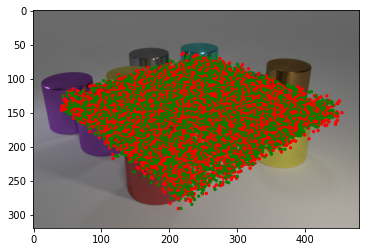

In [15]:
show_distribution(os.path.join(model_dir, 'train_outputs.csv'), dataset_image_dir, preprocess)

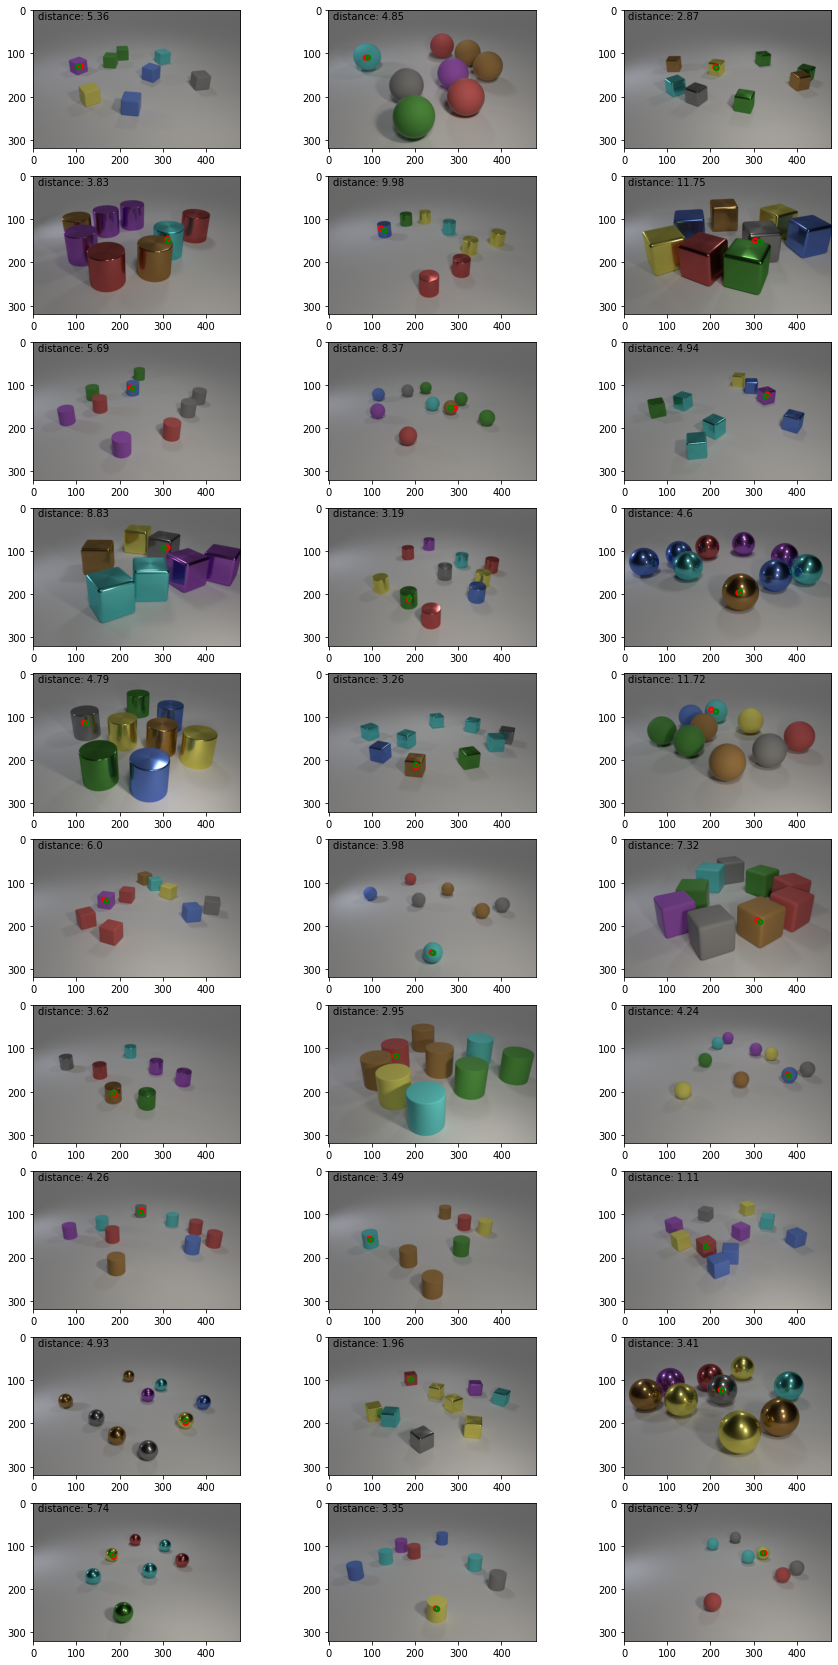

In [16]:
show_picture(os.path.join(model_dir, 'train_outputs.csv'), dataset_image_dir, 30, preprocess)

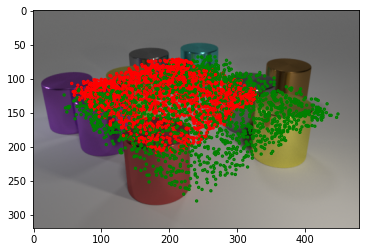

In [17]:
show_distribution(os.path.join(model_dir, 'test_outputs.csv'), dataset_image_dir, preprocess)

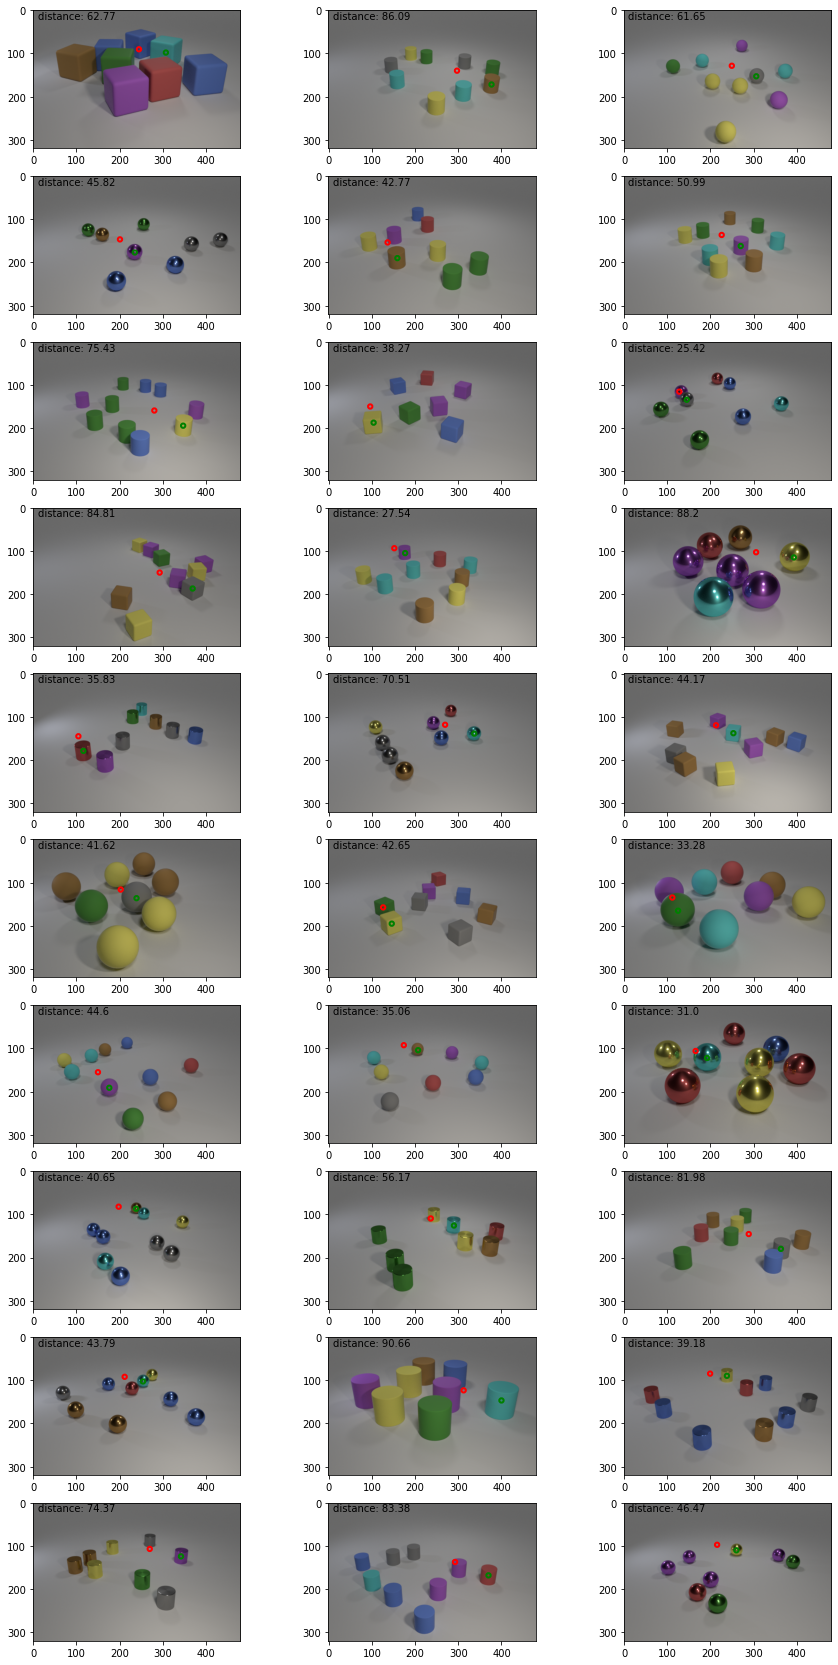

In [18]:
show_picture(os.path.join(model_dir, 'test_outputs.csv'), dataset_image_dir, 30, preprocess)